# Convert a series of calexp into fits files

- author Sylvie Dagoret-Campagne
- creation date 2024-05-14
- last update 2024-05-16
- affiliation : IJCLab
- Kernel **w_2024_16**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [2]:
import gc

In [3]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch

from astropy.time import Time


In [4]:
import lsst.daf.butler as dafButler
#import lsst.summit.utils.butlerUtils as butlerUtils

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom

In [6]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [7]:
transform = AsinhStretch() + PercentileInterval(99.)

### Example to fit a gaussian with astropy

- https://github.com/sylvielsstfr/Fors2pcigale/blob/19-plot-fitted-emission-lines-from-notebooks/src/gelato/Example/ExampleFitInNb.ipynb

In [8]:
from astropy.modeling import models, fitting
from astropy import modeling
# define a model for a line
g_init = models.Gaussian1D(amplitude=1, mean=0, stddev=1)
# initialize a linear fitter
fit_g = fitting.LevMarLSQFitter()

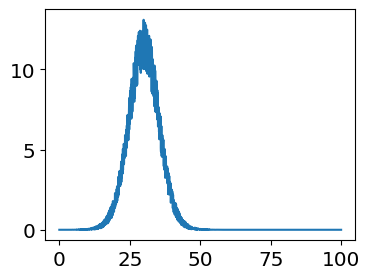

In [9]:
m = modeling.models.Gaussian1D(amplitude=10, mean=30, stddev=5)
x = np.linspace(0, 100, 2000)
data = m(x)
data = data + np.sqrt(data) * np.random.random(x.size) - 0.5
data -= data.min()
plt.plot(x, data)

In [10]:
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D()   # depending on the data you need to give some initial values
fitted_model = fit_g(model, x, data)

In [11]:
fitted_model.mean.value

30.025685830675428

Import statements that we will need later

Let's make a new plot and metric tool, we'll base it on the example in the getting started guide.

In [12]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collectionn = collection
#collections = [collection1,collection2,collection3]
collections = [collection]
collectionStr = collectionn.replace("/", "_")
fn_ccdVisit_tracts_patches = f"ccdVisittractpatch_{collectionStr}.csv"
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864 # mostly for light-curves
patch_sel = 236
band = 'g'
#tract = 5615
# tract = 5634 # interesting to view calib parameters
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

In [13]:
#dataId = {"skymap": "latiss_v1", "tract": 5615, "instrument": "LATISS"}
dataId = {"skymap": skymapName, "tract": tract, "instrument": instrument}
repo = '/sdf/group/rubin/repo/oga/'
butler = dafButler.Butler(repo)
#t = Butler.get(table_sel, dataId=dataId, collections=collections)
registry = butler.registry

In [14]:
skymap_auxtel ='latiss_v1'
skymap = butler.get('skyMap', skymap=skymap_auxtel, collections=collections)

In [15]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [16]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [17]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

## Get Pixel Scale

In [18]:
import lsst.geom as geom
import lsst.sphgeom

skymap = butler.get('skyMap', skymap=skymapName, collections=collections )
tractInfo = skymap.generateTract(tract)
for patch in tractInfo:    
    patchID = patch.getSequentialIndex()
        
    ibb=patch.getInnerBBox()
    tWCS=tractInfo.getWcs()
       
    # loop on the 4 corners
    for icorn,corner in enumerate(ibb.getCorners()):
        p = geom.Point2D(corner.getX(), corner.getY())
        coord = tWCS.pixelToSky(p)

In [19]:
tWCS

FITS standard SkyWcs:
Sky Origin: (122.4365482234, -36.4462809917)
Pixel Origin: (28499, 28499)
Pixel Scale: 0.1 arcsec/pixel

In [20]:
#arcsec/pixel
pixel_scale = tWCS.getPixelScale().asArcseconds()

## Selected visits

In [21]:
if 1:
    # get the csv file produced by stat_on_visits_LSSTAuxtel.ipynb in ../Visits
    #file_selected_visits = "../Visits/ccdVisittractpatch_LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240311_w_2024_10_PREOPS-4985.csv"
    file_selected_visits = os.path.join("../Visits",fn_ccdVisit_tracts_patches)

    df_myselectedvisits = pd.read_csv(file_selected_visits,index_col=0)

    # select the band
    #42614285568    2023112900613
    #42614286592    2023112900617
    #42614287616    2023112900621
    #42614288640    2023112900625
    #42614289664    2023112900629
    #42614290688    2023112900633
    cut = (df_myselectedvisits.visitId ==  2023112900613) | (df_myselectedvisits.visitId == 2023112900617 ) | (df_myselectedvisits.visitId == 2023112900621 ) | (df_myselectedvisits.visitId == 2023112900625 ) | (df_myselectedvisits.visitId == 2023112900629 ) | (df_myselectedvisits.visitId == 2023112900633 )
    df_myselectedvisits = df_myselectedvisits[cut]

    #move the visitid as a column not to loose it during the merge 
    df_myselectedvisits.reset_index(inplace=True) 


In [22]:
df_myselectedvisits

,ccdVisitId,visitId,band,detector,ra,dec,llcra,llcdec,ulcra,ulcdec,...,ccdVid,Vid,nightObs,tractID,patchID,zeroPoint,airmass,skyBg,skyNoise,expTime
0,42614285568,2023112900613,g,0,122.504458,-36.128511,122.438277,-36.182365,122.572358,-36.180966,...,1694588672,61800351,20231129,3864,255,27.941662,1.013989,22.962042,8.504101,30.0
1,42614286592,2023112900617,g,0,122.522607,-36.128485,122.456415,-36.182339,122.590517,-36.180940,...,1694589696,61800355,20231129,3864,255,27.902847,1.012274,20.295702,8.357081,30.0
2,42614287616,2023112900621,g,0,122.540279,-36.128302,122.474097,-36.182154,122.608184,-36.180755,...,1694590720,61800359,20231129,3864,255,27.838533,1.010761,18.873140,8.293358,30.0
3,42614288640,2023112900625,g,0,122.558387,-36.128219,122.492206,-36.182075,122.626291,-36.180676,...,1694591744,61800363,20231129,3864,255,27.761272,1.009438,17.706266,8.229728,30.0
4,42614289664,2023112900629,g,0,122.429545,-36.206799,122.363304,-36.260652,122.497521,-36.259259,...,1694592768,61800367,20231129,3864,237,27.677470,1.008283,16.589357,8.206800,30.0
5,42614290688,2023112900633,g,0,122.447779,-36.206725,122.381542,-36.260580,122.515752,-36.259188,...,1694593792,61800371,20231129,3864,237,27.592865,1.007370,15.506880,8.169852,30.0


Note here:
- zeroPoint is in ABMag
- skyBg is in ADU (but don't know if in pixel or in arcsec2)
- skyNoise is in ADU (but don't know if in pixel or in arcsec2)

In [23]:
index = 5
visitId = df_myselectedvisits.iloc[index]['visitId']

In [24]:
df_myselectedvisits.iloc[index]

ccdVisitId      42614290688
visitId       2023112900633
band                      g
detector                  0
ra               122.447779
dec              -36.206725
llcra            122.381542
llcdec            -36.26058
ulcra            122.515752
ulcdec           -36.259188
urcra            122.513925
urcdec           -36.152834
lrcra            122.379897
lrcdec           -36.154224
ccdVid           1694593792
Vid                61800371
nightObs           20231129
tractID                3864
patchID                 237
zeroPoint         27.592865
airmass             1.00737
skyBg              15.50688
skyNoise           8.169852
expTime                30.0
Name: 5, dtype: object

In [25]:
datasetType = 'calexp'
dataId = {'visit': visitId, 'instrument':instrument , 'detector': 0}
datasetRefs = registry.queryDatasets(datasetType, dataId=dataId, collections  = collections)

for i, ref in enumerate(datasetRefs):
    print(ref.dataId)
    print("band:", ref.dataId['band'])
    band = ref.dataId['band']

{instrument: 'LATISS', detector: 0, visit: 2023112900633, band: 'g', day_obs: 20231129, physical_filter: 'SDSSg_65mm~empty'}
band: g


## One Calexp 

In [26]:
calexp = butler.get('calexp', **dataId,collections=collections)
mask = calexp.mask.array

In [27]:
the_mask = np.where(mask==0,1,0)
the_mask.shape

(4000, 4072)

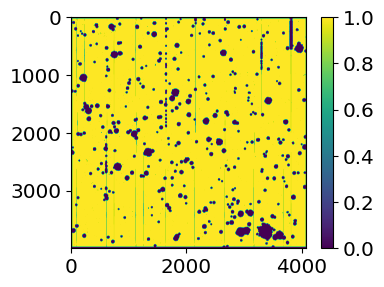

In [28]:
im = plt.imshow(the_mask)
plt.colorbar(im)

In [29]:
img = calexp.image.array * (the_mask)

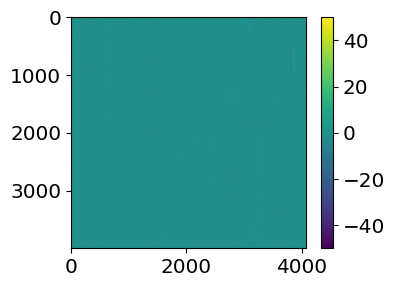

In [30]:
im=plt.imshow(img,vmin=-50,vmax=50)
plt.colorbar(im)

1.8268201 0.19073412 8.487394229221344 -49.80926588177681 50.19073411822319 -342.52625 41975.12
fig_g parameters:  Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean             stddev     
    ----------------- ----------------- -----------------
    782948.9501904608 0.608519793221374 8.226272499606099


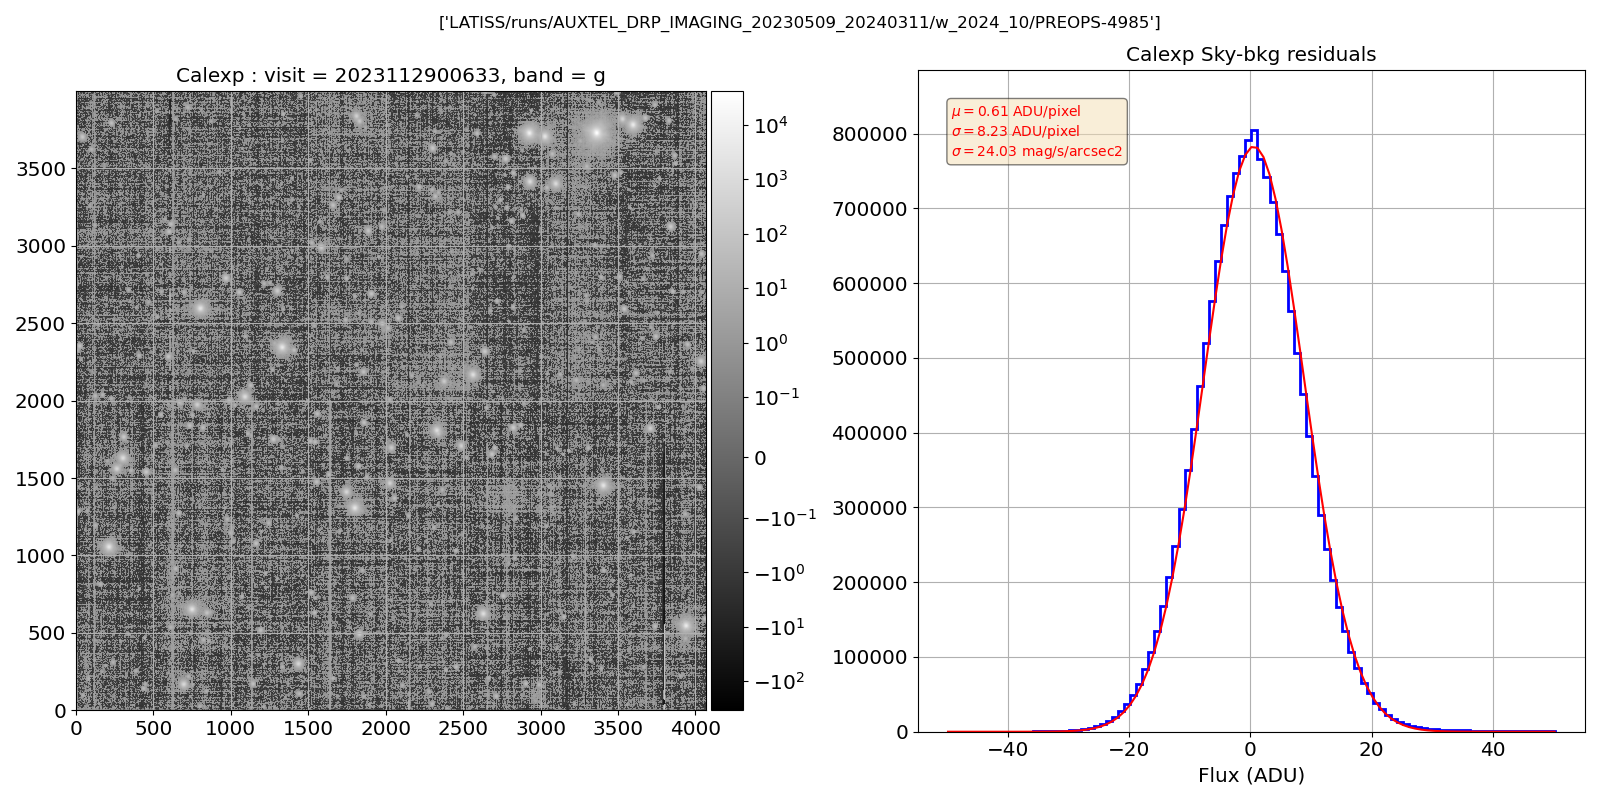

In [31]:
%matplotlib widget

calexp = butler.get('calexp', **dataId,collections=collections)

calexp_info = calexp.getInfo()
photocalib = calexp_info.getPhotoCalib()
expo_photocalibconstant_mean = photocalib.getCalibrationMean()
expo_photocalibconstant_error = photocalib.getCalibrationErr()
calexp_md = calexp_info.getMetadata()
magzero,magzero_rms,magzero_nobj = calexp_md["MAGZERO"],calexp_md["MAGZERO_RMS"],calexp_md["MAGZERO_NOBJ"] 
bgmean,bgvar = calexp_md["BGMEAN"],calexp_md["BGVAR"]

mask = calexp.mask.array
the_mask = np.where(mask==0,1,0)
#img = calexp.maskedImage.getImage()
img = calexp.image.array 
#img = calexp[the_mask] 
#wcs = img.getWcs()
#bbox = img.getBBox()
#corners_ra, corners_dec = get_corners_radec(wcs, bbox)
#extent = [np.min(corners_ra),np.max(corners_ra),np.min(corners_dec),np.max(corners_dec)]


# Display the image with a suitable scaling
data_flat = img.flatten()
mean = np.mean(data_flat)
med = np.median(data_flat)
sigMad = 1.4826 * np.median(np.fabs(data_flat - mean))
#vmin = med - 3 * sigMad
#vmax = med + 3 * sigMad
vmin = med - 50.
vmax = med + 50.
the_min= data_flat.min()
the_max= data_flat.max()
print(mean,med ,sigMad ,vmin ,vmax,the_min,the_max )

fig,axs = plt.subplots(1,2,figsize=(16,8))

## Plot the image
ax = axs[0]
from astropy.visualization import ZScaleInterval
z = ZScaleInterval()
z1,z2 = z.get_limits(img)
from matplotlib.colors import SymLogNorm
im=ax.imshow(img, origin="lower", cmap="grey",norm=SymLogNorm(linthresh=0.1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
the_title = f"Calexp : visit = {visitId}, band = {band}"
ax.set_title(the_title)
ax.grid()
ax.set_aspect('equal')
plt.colorbar(im, cax=cax,ax=ax)



ax = axs[1]

#val = data_flat/med)
#data_flat_mag = -2.5*np.log10((data_flat/med))*1000
#mu_mag = np.mean(data_flat_mag)
#med_mag = np.median(data_flat_mag)
#sigMad_mag = 1.4826 * np.median(np.fabs(data_flat_mag - med_mag))
#vmin_mag = med_mag - 3 * sigMad_mag
#vmax_mag = med_mag + 3 * sigMad_mag
#textstr = '\n'.join((
#    r'$\mu=%.2f$ mmag' % (mu_mag, ),
#    r'$\mathrm{med}=%.2f$ mmag' % (med_mag, ),
#    r'$\sigma=%.2f$ mmag' % (sigMad_mag , )))

data_flat_nozero = data_flat[~(data_flat==0)]
histdata  = ax.hist(data_flat_nozero,bins=100,range=(vmin,vmax),histtype="step",color="b",lw=2)
histarray,histedges = histdata[0],histdata[1]
ax.set_ylim(0.,histarray.max()*1.1)

# fit
g = fit_g(g_init,histedges[1:],histarray)
print("fig_g parameters: ",g)
m = modeling.models.Gaussian1D(amplitude=g.amplitude.value, mean=g.mean.value, stddev=g.stddev.value)
ax.plot(histedges,m(histedges),"r-")
textstr = '\n'.join((
    r'$\mu=%.2f$ ADU/pixel' % (g.mean.value, ),
    r'$\sigma=%.2f$ ADU/pixel' % (g.stddev.value , ),
    r'$\sigma=%.2f$ mag/s/arcsec2' % (convert_fluxtomag(g.stddev.value*expo_photocalibconstant_mean/30./pixel_scale**2) ,)))
props = dict(boxstyle='round', facecolor='wheat' ,alpha=0.5)
ax.text(0.05, 0.95, textstr, color="r",transform=ax.transAxes, fontsize=10,verticalalignment='top', bbox=props)
ax.set_title("Calexp Sky-bkg residuals")
ax.set_xlabel("Flux (ADU)")

ax.grid()

plt.suptitle(collections)
plt.tight_layout()
plt.show()
#remove_figure(fig)

In [32]:
md = calexp_md.toDict() 
arr= img
# 180 degree rotation
rotated_array = arr[::-1,::-1] #rotate the array 180 degrees
filename_out = f"exposure_{visitId}_calexp.fits"

In [33]:
hdr = fits.Header()
for key,value in md.items():
    if len(key)<19:
        hdr[str(key)]=value

In [34]:
primary_hdu = fits.PrimaryHDU(header=hdr)
image_hdu = fits.ImageHDU(rotated_array)
hdu_list = fits.HDUList([primary_hdu, image_hdu])
hdu_list.writeto(filename_out,overwrite=True)    